In [2]:
import numpy as np

In [5]:
obstacle = np.load("preprocessing/pysocialforce_obstacles_meter/00_Zurich_HB_anchored.npy")
print(obstacle)

[[  6.46999194   6.87436644 242.62469781 242.62469781]
 [  6.46999194   6.46999194 242.62469781 242.22032332]
 [  6.87436644   7.27874093 242.62469781 242.62469781]
 ...
 [243.4334468  243.8378213    0.4043745    0.4043745 ]
 [243.4334468  243.8378213    0.           0.        ]
 [243.8378213  243.8378213    0.4043745    0.        ]]


Grid size: 262 x 246


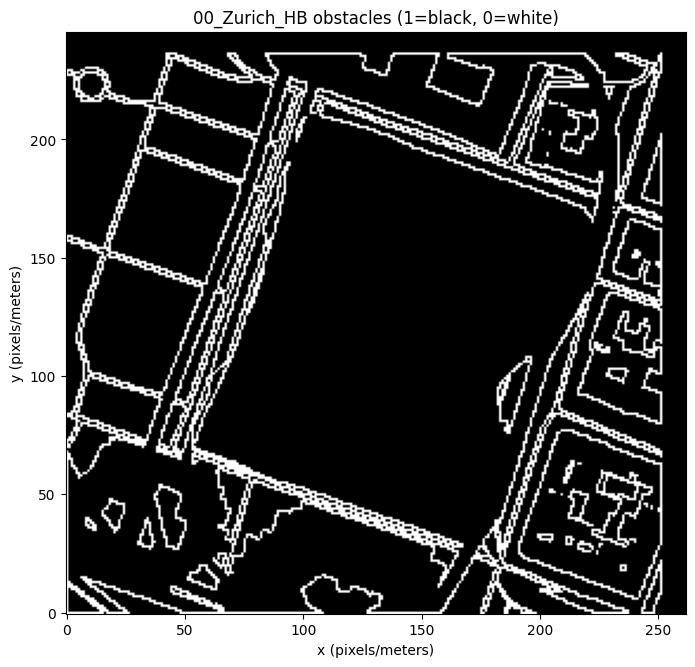

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Load obstacles: rows are (x_min, x_max, y_min, y_max) in meters
obs = np.load("preprocess/pysocialforce_obstacles_meter/14_Châtelet_Les_Halles_anchored.npy")

# Compute bounds for the raster
min_x = np.floor(obs[:, 0].min()).astype(int)
max_x = np.ceil(obs[:, 1].max()).astype(int)
min_y = np.floor(obs[:, 2].min()).astype(int)
max_y = np.ceil(obs[:, 3].max()).astype(int)

width = max_x - min_x + 10
height = max_y - min_y + 10
print(f"Grid size: {width} x {height}")

# Rasterize obstacles
grid = np.zeros((height, width), dtype=np.uint8)
thickness = 1  # increase for thicker lines

def draw_segment(x0, x1, y0, y1):
    # sample along the segment; more samples = less gaps
    steps = max(int(np.hypot(x1 - x0, y1 - y0) * 2), 1)
    xs = np.linspace(x0, x1, steps) - min_x
    ys = np.linspace(y0, y1, steps) - min_y
    xi = np.clip(xs.round().astype(int), 0, width - 1)
    yi = np.clip(ys.round().astype(int), 0, height - 1)
    grid[yi, xi] = 1
    if thickness > 1:
        for dx in range(-thickness + 1, thickness):
            for dy in range(-thickness + 1, thickness):
                xj = np.clip(xi + dx, 0, width - 1)
                yj = np.clip(yi + dy, 0, height - 1)
                grid[yj, xj] = 1

for x0, x1, y0, y1 in obs:
    draw_segment(x0, x1, y0, y1)


# Plot
plt.figure(figsize=(8, 8))
plt.imshow(grid, origin="lower", cmap="gray")
plt.title("00_Zurich_HB obstacles (1=black, 0=white)")
plt.xlabel("x (pixels/meters)")
plt.ylabel("y (pixels/meters)")
plt.show()


In [15]:
# load npz file and print its content

# Load the npz file
data = np.load("sim/results/simulations/sim_00_Zurich_HB_1766256107.npz", allow_pickle=True)

# Print the keys in the npz file
print("Keys in the npz file:", list(data.keys()))

# Print the content of each array
for key in data.keys():
    print(f"Content of {key}:")
    print(data[key])

Keys in the npz file: ['states', 'scene']
Content of states:
[[[ 1.79398573e+02  1.05855370e+02 -7.05456271e-01 ...  1.73881033e+02
    9.82630026e+01  5.00000000e-01]
  [ 1.86685288e+02  1.27649868e+02 -1.01322630e+00 ...  8.45142697e+01
    1.92482260e+02  5.00000000e-01]
  [ 1.69117149e+02  1.04717171e+02  7.25327386e-01 ...  2.48285941e+02
    2.09061615e+02  5.00000000e-01]
  ...
  [ 1.77575224e+02  1.14523117e+02 -9.19877348e-01 ...  8.45142697e+01
    1.92482260e+02  5.00000000e-01]
  [ 1.93360805e+02  1.14504278e+02  6.02733934e-01 ...  2.48285941e+02
    2.09061615e+02  5.00000000e-01]
  [ 1.74056203e+02  1.02059915e+02 -6.83335788e-01 ...  1.16459855e+02
    1.85203519e+02  5.00000000e-01]]

 [[ 1.78775935e+02  1.05896575e+02 -1.55659516e+00 ...  1.73881033e+02
    9.82630026e+01  5.00000000e-01]
  [ 1.86064637e+02  1.27585307e+02 -1.55162774e+00 ...  8.45142697e+01
    1.92482260e+02  5.00000000e-01]
  [ 1.68760713e+02  1.04936504e+02 -8.91089998e-01 ...  2.48285941e+02
    

In [50]:
# Cell 1 — Imports
# !pip install opencv-python numpy matplotlib

import cv2
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt


In [57]:
# Cell 2 — Load gray (handles alpha)
def load_gray(path: str) -> np.ndarray:
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(path)

    # RGBA -> composite on white background
    if img.ndim == 3 and img.shape[2] == 4:
        bgr = img[:, :, :3].astype(np.float32)
        a = img[:, :, 3:4].astype(np.float32) / 255.0
        white = np.full_like(bgr, 255.0)
        comp = (bgr * a + white * (1 - a)).astype(np.uint8)
        return cv2.cvtColor(comp, cv2.COLOR_BGR2GRAY)

    if img.ndim == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


In [58]:
# Cell 3 — Fixed convention binarize: BLACK = obstacle
def binarize_black_is_obstacle(gray: np.ndarray, thresh: int = 200) -> np.ndarray:
    """
    Returns obstacle mask: obstacles=255, background=0
    Convention: black pixels are obstacles.
    """
    obstacles = np.zeros_like(gray, dtype=np.uint8)
    obstacles[gray < thresh] = 255
    return obstacles


In [59]:
# Cell 4 — Utility: scale polygon towards its centroid (shrink)
def shrink_polygon(pts_xy: np.ndarray, factor: float) -> np.ndarray:
    """
    pts_xy: (N,2) float or int
    factor < 1.0 shrinks towards centroid
    """
    pts = pts_xy.astype(np.float32)
    c = pts.mean(axis=0, keepdims=True)
    pts2 = c + factor * (pts - c)
    return np.round(pts2).astype(np.int32)

def draw_component_mask(shape, contour) -> np.ndarray:
    m = np.zeros(shape, dtype=np.uint8)
    cv2.drawContours(m, [contour], -1, 255, thickness=-1)
    return m

def iou_score(mask_a: np.ndarray, mask_b: np.ndarray) -> float:
    inter = np.logical_and(mask_a > 0, mask_b > 0).sum()
    union = np.logical_or(mask_a > 0, mask_b > 0).sum()
    return float(inter) / float(union + 1e-9)


In [60]:
# Cell 5 — Fit ONE primitive per component (triangle first, else best of rect/circle)
def fit_one_primitive(component_mask: np.ndarray,
                      shrink_factor: float = 0.90,
                      tri_eps_ratio: float = 0.06):
    """
    component_mask: uint8, 255=component, 0=bg (already isolated)
    Returns: ('triangle'/'rect'/'circle', params_dict, draw_mask255)
    """
    # find contour
    contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    if area < 5:
        return None

    h, w = component_mask.shape[:2]
    target = draw_component_mask((h, w), cnt)

    # --- Triangle candidate (only if approx gives 3 vertices)
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, tri_eps_ratio * peri, True)
    best = None

    if len(approx) == 3:
        tri = approx.reshape(-1, 2)
        tri = shrink_polygon(tri, shrink_factor)
        tri_mask = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(tri_mask, [tri], 255)
        tri_iou = iou_score(target, tri_mask)
        best = ("triangle", {"points": tri.tolist()}, tri_mask, tri_iou)

    # --- Rotated rectangle candidate
    rect = cv2.minAreaRect(cnt)  # ((cx,cy),(rw,rh),angle)
    box = cv2.boxPoints(rect)    # 4x2 float
    box = shrink_polygon(box, shrink_factor)
    rect_mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(rect_mask, [box], 255)
    rect_iou = iou_score(target, rect_mask)

    rect_candidate = ("rect", {"points": box.tolist()}, rect_mask, rect_iou)

    # --- Circle candidate
    (cx, cy), r = cv2.minEnclosingCircle(cnt)
    r2 = max(1.0, r * shrink_factor)
    circ_mask = np.zeros((h, w), dtype=np.uint8)
    cv2.circle(circ_mask, (int(round(cx)), int(round(cy))), int(round(r2)), 255, thickness=-1)
    circ_iou = iou_score(target, circ_mask)

    circ_candidate = ("circle", {"center": [float(cx), float(cy)], "radius": float(r2)}, circ_mask, circ_iou)

    # choose best among available
    candidates = [rect_candidate, circ_candidate]
    if best is not None:
        candidates.append(best)

    chosen = max(candidates, key=lambda x: x[3])
    shape_name, params, draw_mask, score = chosen
    return shape_name, params, draw_mask


In [ ]:
# Cell 6 — Main: (1) shrink obstacles (erosion) to avoid merging, (2) CC, (3) 1 primitive per CC
def simplify_obstacles_one_shape_each(input_png: str,
                                      out_dir: str = "outputs",
                                      thresh: int = 200,
                                      erosion_ksize: int = 0,
                                      erosion_iters: int = 1,
                                      min_component_area: int = 200,
                                      shrink_factor: float = 0.90):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    gray = load_gray(input_png)
    obstacles = binarize_black_is_obstacle(gray, thresh=thresh)  # 255 obstacle

    # Erode to make big obstacles smaller + separate close ones
    if erosion_ksize and erosion_ksize > 1 and erosion_iters > 0:
        k = cv2.getStructuringElement(cv2.MORPH_RECT, (erosion_ksize, erosion_ksize))
        obstacles_eroded = cv2.erode(obstacles, k, iterations=erosion_iters)
    else:
        obstacles_eroded = obstacles.copy()

    # Original normalized (what you feed in, black=obstacle)
    original_norm = np.full_like(obstacles, 255)
    original_norm[obstacles == 255] = 0

    # Simplified canvas (white background)
    simplified = np.full_like(obstacles, 255)

    # Connected components on eroded mask
    num, labels, stats, _ = cv2.connectedComponentsWithStats((obstacles_eroded > 0).astype(np.uint8), connectivity=8)

    # For each component, fit exactly ONE primitive and draw it
    for cid in range(1, num):
        x, y, w, h, area = stats[cid]
        if area < min_component_area:
            continue

        comp = (labels == cid).astype(np.uint8) * 255

        fit = fit_one_primitive(comp, shrink_factor=shrink_factor)
        if fit is None:
            continue

        _, _, draw_mask = fit
        # draw onto global canvas (black obstacles)
        simplified[draw_mask == 255] = 0

    base = Path(input_png).stem
    # out_original = out_dir / f"{base}_original_norm.png"
    base_clean = base.removesuffix("_obstacle")
    out_simplified = out_dir / f"{base_clean}_simplified_obstacle.png"

    cv2.imwrite(str(out_original), original_norm)
    cv2.imwrite(str(out_simplified), simplified)

    plt.figure(figsize=(6,4))
    plt.title("Simplified — one primitive per obstacle segment (no lines)")
    plt.imshow(simplified, cmap="gray")
    plt.axis("off")
    plt.show()

    return str(out_simplified)


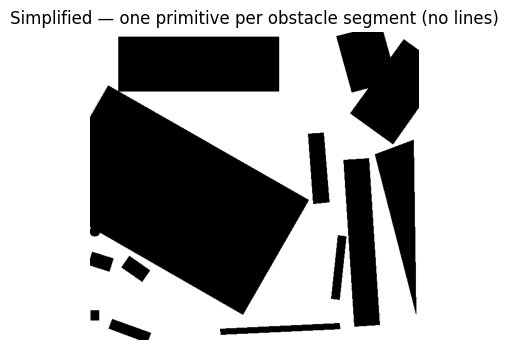

Saved: outputs/00_Zurich_HB_simplified_obstacle.png


In [ ]:
# Cell 7 — Run
input_png = "downloads/google_maps/obstacles/00_Zurich_HB_obstacle.png"  # <- change
simp_path = simplify_obstacles_one_shape_each(
    input_png,
    out_dir="outputs",
    thresh=200,
    erosion_ksize=4,      # ↑ 大一点 -> 障碍更“瘦”、更不容易连
    erosion_iters=5,      # ↑ 迭代多 -> 更瘦，但可能断裂
    min_component_area=150,
    shrink_factor=0.85    # ↓ 更小(0.85) -> 更不容易粘连
)
print("Saved:", orig_path)
print("Saved:", simp_path)


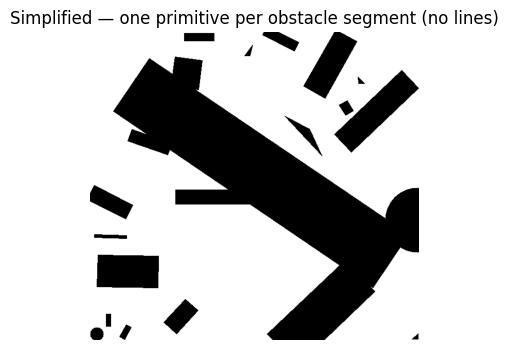

Saved: downloads/google_maps/simplified_obstacles/114_Porta_Portese_Market_simplified_obstacle.png


In [604]:
# Cell 7 — Run
input_png = "downloads/google_maps/obstacles/114_Porta_Portese_Market_obstacle.png"  # <- change
simp_path = simplify_obstacles_one_shape_each(
    input_png,
    out_dir="downloads/google_maps/simplified_obstacles",
    thresh=150,
    erosion_ksize=5,      # ↑ 大一点 -> 障碍更“瘦”、更不
    erosion_iters=5,      # ↑ 迭代多 -> 更瘦，但可
    min_component_area=100,
    shrink_factor=0.8 # ↓ 更小(0.85) -> 更不容易粘
)
print("Saved:", simp_path)


[[ 12.53560939  12.93998388 197.73912872 197.73912872]
 [ 19.00560133  19.81435032 197.73912872 197.73912872]
 [215.93598105 217.55347904 197.73912872 197.73912872]
 ...
 [ 61.06054895  61.06054895  54.18618251  53.78180801]
 [145.17044419 145.17044419  63.48679593  62.67804694]
 [212.70098508 212.70098508 190.05601329 189.65163879]]


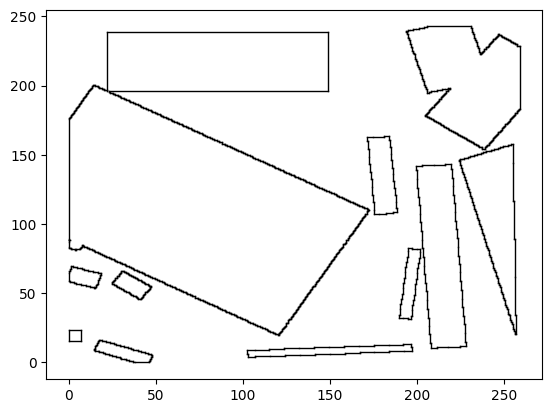

In [95]:
obs = np.load("outputs/00_Zurich_HB_obstacles_lines_precise.npz")
print(obs["obstacles"])
# (x_min, x_max, y_min, y_max)
    # obs = [[-1, -1, -1, 11], [3, 3, -1, 11]]
for item in obs["obstacles"]:
    #draw lines in items with (x_min, x_max, y_min, y_max) format
    x_min, x_max, y_min, y_max = item
    plt.plot([x_min, x_max], [y_min, y_max], linewidth=1, color='black')


[[    0.         -2303.68727593     0.         14194.61194554]
 [-2471.441081   -2576.59901892 15228.25925966 15876.21010671]
 [-1469.74930005 -3029.71969199 20576.51946122 16404.28923698]
 [-2915.85024208 -2859.01439222 16708.83960727 16860.85034533]
 [-3029.71969199 -2303.68727593 16404.28923698 14194.61194554]
 [-1469.74930005     0.         20576.51946122     0.        ]
 [-2915.85024208 -2471.441081   16708.83960727 15228.25925966]
 [-2859.01439222 -2576.59901892 16860.85034533 15876.21010671]]


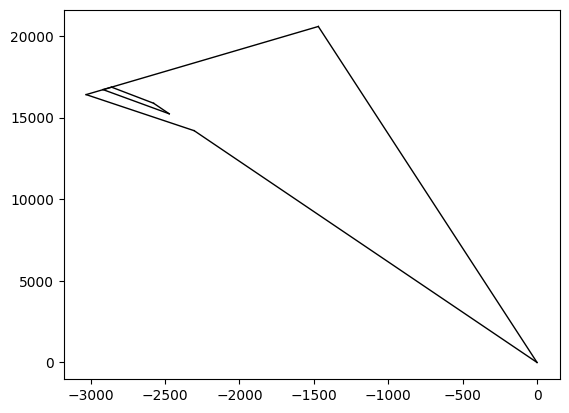

In [7]:
import numpy as np
import matplotlib.pyplot as plt
obs = np.load("preprocess/pysfm_obstacles_meter_close_shape/gt_eth_simplified_obstacle.npz")
print(obs["obstacles"])
# (x_min, x_max, y_min, y_max)
    # obs = [[-1, -1, -1, 11], [3, 3, -1, 11]]
for item in obs["obstacles"]:
    #draw lines in items with (x_min, x_max, y_min, y_max) format
    x_min, x_max, y_min, y_max = item
    plt.plot([x_min, x_max], [y_min, y_max], linewidth=1, color='black')


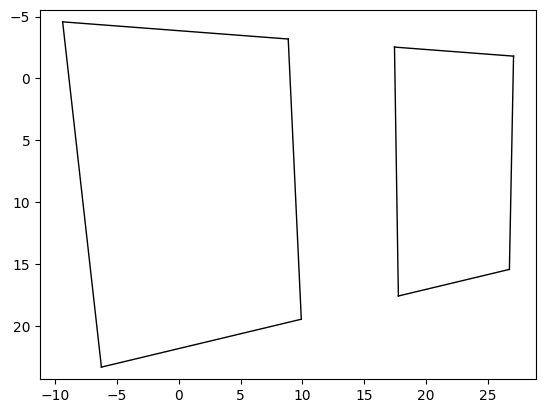

In [8]:
import numpy as np
import matplotlib.pyplot as plt

obs = np.load("preprocess/pysfm_obstacles_meter_close_shape/gt_eth_simplified_obstacle_anchored.npz")["obstacles"]

plt.figure()
for x0, x1, y0, y1 in obs:
    plt.plot([x0, x1], [y0, y1], color="black", linewidth=1)

plt.gca().invert_yaxis()      # match image convention (optional)
plt.axis("equal")
plt.show()


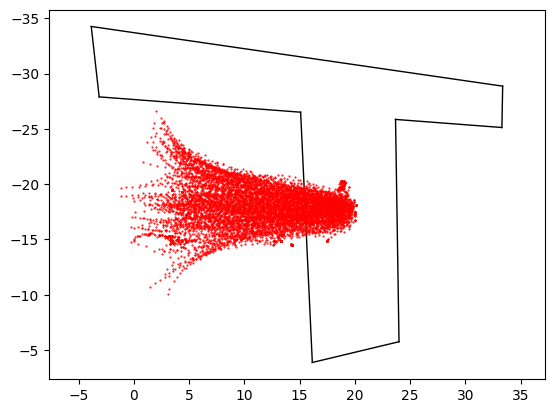

In [13]:
import numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from utils.convert_obstacle_to_meter import load_homography, apply_homography

gt_dir = Path("downloads/gt/eth/obstacle")
obs = np.load("preprocess/pysfm_obstacles_meter_close_shape/gt_eth_simplified_obstacle.npz")["obstacles"]

# same anchor used for obstacles
H_px_to_world = load_homography(gt_dir / "H.txt")
origin_px = np.array([[0.0, float(Image.open(gt_dir / "reference_mask.png").height)]])
origin_m = apply_homography(origin_px, H_px_to_world)[0]

tracks = np.loadtxt(gt_dir / "obsmat.txt")
world_xy = tracks[:, [2, 4]]
anchored_xy = world_xy - origin_m  # align with anchored obstacle frame

plt.figure()
for x0, x1, y0, y1 in obs:
    plt.plot([x0, x1], [y0, y1], color="black", linewidth=1)
plt.plot(anchored_xy[:, 0], anchored_xy[:, 1], "r.", markersize=1)
plt.gca().invert_yaxis()
plt.axis("equal")
plt.show()


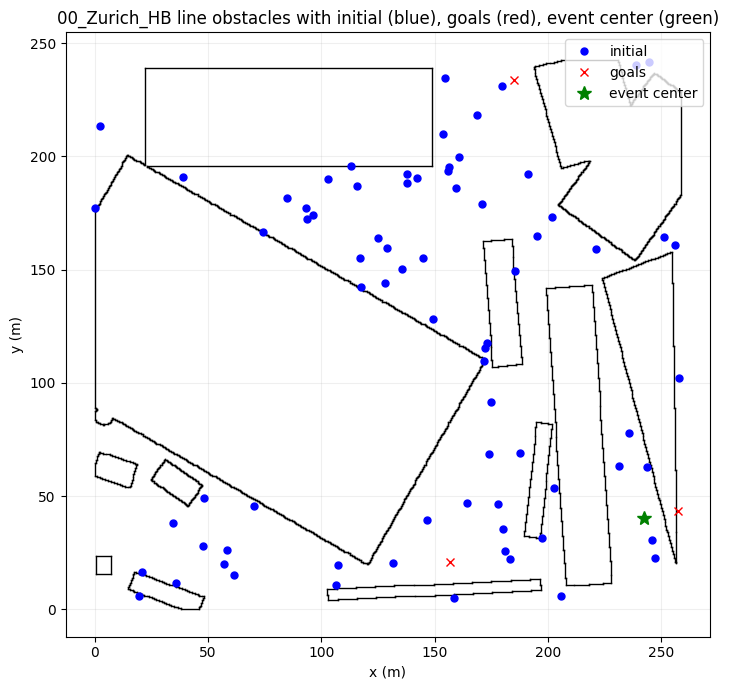

In [105]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
scene_path = Path("preprocess/preprocessed_scene/0051_00_Zurich_HB_obstacle_simplified.json")
line_obs_path = Path("preprocess/pysfm_obstacles_meter_close_shape/00_Zurich_HB_obstacle_simplified_anchored.npz")

# Load scene data
with scene_path.open("r", encoding="utf-8") as f:
    data = json.load(f)

# Load line obstacles (x_min, x_max, y_min, y_max) in meters
line_obstacles = np.load(line_obs_path)["obstacles"]

plt.figure(figsize=(8, 7))

# Draw obstacles
for x_min, x_max, y_min, y_max in line_obstacles:
    plt.plot([x_min, x_max], [y_min, y_max], color="black", linewidth=1, label="obstacle" if x_min is line_obstacles[0][0] else None)

# Plot initial positions (meters)
initial_state = np.array(data["initial_state"], dtype=float)
plt.plot(initial_state[:, 0], initial_state[:, 1], "o", color="blue", markersize=5, label="initial")

# Plot goals (meters)
goals = np.array(data["goals_m"], dtype=float)
plt.plot(goals[:, 0], goals[:, 1], "x", color="red", markersize=6, label="goals")

# Plot event center if present
event = data.get("event_center_m")
if isinstance(event, list) and len(event) == 2 and all(isinstance(v, (int, float)) for v in event):
    plt.plot(event[0], event[1], "*", color="green", markersize=10, label="event center")

plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("00_Zurich_HB line obstacles with initial (blue), goals (red), event center (green)")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()
